In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler



In [3]:
data= pd.read_csv("eda_done_data.csv")
df= pd.DataFrame(data)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.384214,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,140.00,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.817386,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,140.00,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
X= df.drop('Class', axis=1)
y= df['Class']

In [9]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
sclaer= StandardScaler()
X_train_scaled= sclaer.fit_transform(X_train)
X_test_scaled= sclaer.transform(X_test)


In [12]:
models = {
    "LogisticRegression": LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),

    "SGDClassifier": SGDClassifier(
        loss="log_loss",
        class_weight="balanced",
        random_state=42
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    ),

    "BalancedRandomForest": BalancedRandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    ),

    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ),

    "EasyEnsemble": EasyEnsembleClassifier(
        n_estimators=200,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=580,
        eval_metric="auc",
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        class_weight="balanced",
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        loss_function="Logloss",
        verbose=False,
        random_seed=42
    )
}


In [13]:
X_train_sm, y_train_sm = SMOTE().fit_resample(X_train, y_train)


In [15]:
results=[]

In [16]:
for name, model in models.items():

    # Train model
    if name in ["LogisticRegression", "SGDClassifier"]:
        model.fit(X_train_sm, y_train_sm)
    else:
        model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Probabilities and ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report as dict
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store everything
    results.append({
        "model": name,
        "roc_auc": roc_auc,
        "precision_fraud": report["1"]["precision"],
        "recall_fraud": report["1"]["recall"],
        "f1_fraud": report["1"]["f1-score"],
        "tn": cm[0][0],
        "fp": cm[0][1],
        "fn": cm[1][0],
        "tp": cm[1][1]
    })


c:\Users\naman\OneDrive\Desktop\FraudShield\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [17]:
FAST_ESTIMATORS = 100

models_fast = {
    "LogisticRegression": LogisticRegression(
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ),

    "BalancedRandomForest": BalancedRandomForestClassifier(
        n_estimators=FAST_ESTIMATORS,
        n_jobs=-1,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=FAST_ESTIMATORS,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=580,
        eval_metric="auc",
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=FAST_ESTIMATORS,
        learning_rate=0.1,
        class_weight="balanced",
        random_state=42
    )
}


In [18]:
import time
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

results = []

for name, model in models_fast.items():
    start_time = time.time()

    # Train
    if name == "LogisticRegression":
        model.fit(X_train_sm, y_train_sm)
    else:
        model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    elapsed = round(time.time() - start_time, 2)

    results.append({
        "model": name,
        "roc_auc": roc_auc,
        "precision_fraud": report["1"]["precision"],
        "recall_fraud": report["1"]["recall"],
        "f1_fraud": report["1"]["f1-score"],
        "train_time_sec": elapsed,
        "tn": cm[0][0],
        "fp": cm[0][1],
        "fn": cm[1][0],
        "tp": cm[1][1]
    })

results_df = pd.DataFrame(results)


c:\Users\naman\OneDrive\Desktop\FraudShield\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [20]:
results_df.sort_values("roc_auc", ascending=False)


,model,roc_auc,precision_fraud,recall_fraud,f1_fraud,train_time_sec,tn,fp,fn,tp
1,BalancedRandomForest,0.975255,0.122392,0.897959,0.215422,8.90,56233,631,10,88
2,XGBoost,0.974787,0.618705,0.877551,0.725738,9.42,56811,53,12,86
0,LogisticRegression,0.971577,0.069510,0.897959,0.129032,29.69,55686,1178,10,88
3,LightGBM,0.969626,0.800000,0.857143,0.827586,2.82,56843,21,14,84


In [22]:
best_model= models_fast["BalancedRandomForest"]


In [24]:

from sklearn.metrics import precision_recall_curve


y_prob = best_model.predict_proba(X_test)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

best_threshold

np.float64(0.94)

In [25]:
y_pred_opt = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.79      0.79        98

    accuracy                           1.00     56962
   macro avg       0.89      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [26]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_test, y_prob)
pr_auc


0.7375447453875146

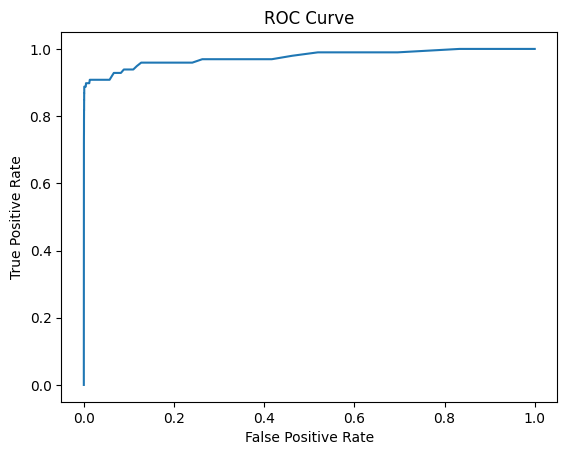

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


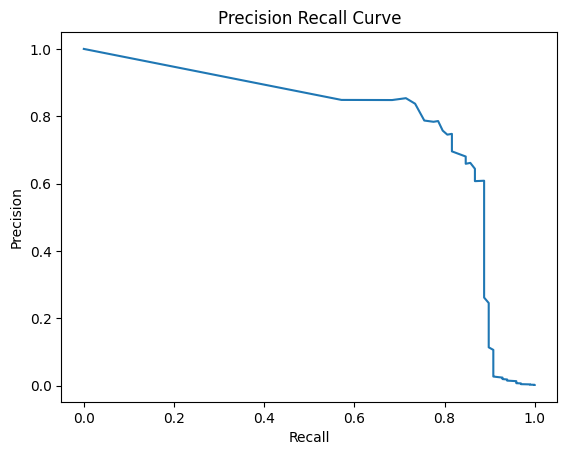

In [29]:
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.show()


In [28]:
import pandas as pd

importance = pd.Series(
    best_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)


V14    0.149280
V4     0.130506
V10    0.114467
V12    0.101163
V16    0.077202
V3     0.076727
V17    0.066021
V11    0.040012
V2     0.030596
V7     0.023805
dtype: float64

In [30]:
import joblib

joblib.dump(best_model, "fraud_model.pkl")


['fraud_model.pkl']